# Identify outliers in scraped datasets using Easy-ICD

In this notebook we show how to train an outlier detector to identify distracting images and noise in scraped image datasets.

## Required imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize

from sklearn.manifold import TSNE

from easy_icd.utils.datasets import create_dataset
from easy_icd.utils.augmentation import RandomImageAugmenter
from easy_icd.training.train_models import train_model
from easy_icd.utils.models import ResNet

## Create dataset

First, we create train and test splits for a scraped dataset:

In [6]:
img_dir = 'marine_animals'
class_names = ['hammerhead shark', 'orca whale', 'manta ray', 'jellyfish', 'axolotl']
one_hot_labels = False
scale_images = True
train_test_split_ratio = 0.8

train_ds, test_ds = create_dataset(img_dir, class_names, one_hot_labels, scale_images, train_test_split_ratio)
train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=4, shuffle=True)

## Create model

Next, we create a machine learning model that we train on the scraped data. Easy-ICD supports creating ResNet models via one function call, although we could use other PyTorch models if we wanted to. Here, we create a small ResNet-8 that contains a convolutional stem, 3 conv / batch norm blocks, and a non-linear projection head. We set the size of the projection head using the `linear_sizes` argument to the constructor, and tell Easy-ICD that we want to train the model using an unsupervised method by setting `supervised = False`. This removes the final output layer of the model that would give us the logits for each class in the dataset.

In [7]:
num_layers = 3
num_blocks = [1, 1, 1]
in_channels = 3
out_channels = [16, 32, 64]
linear_sizes = [128, 32]
supervised = False

model = ResNet(num_layers, num_blocks, in_channels, out_channels, linear_sizes, supervised)

In [8]:
model

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResNetBasicBlock(
      (layers): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): ResNetBasicBlock(
      (layers): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

We can see how many parameters the model has in total:

In [9]:
all_params = 0

for module in model.modules():
    if 'weight' in module.state_dict().keys():
        all_params += np.prod(module.state_dict()['weight'].size())

    if 'bias' in module.state_dict().keys():
        all_params += np.prod(module.state_dict()['bias'].size())
        
print('Total parameters in model:', all_params)

Total parameters in model: 98032


## Train outlier detector

Now that we have a training set, a test set, and a model, we can train the model on the scraped images. We use a modified version of the SimCLR loss to train the model, although we could use the regular cross-entropy loss, or even the original SimCLR loss instead. Easy-ICD makes training outlier detectors extremely easy, requiring just one function call.

The `img_size` variable is set to the size of the images in the dataset we are training the model on. if you are using the model on images of a different size, change the variable to the correct value. We create a `RandomImageAugmenter` to make it easy to create augmented versions of images from the dataset, which we need to train the model using the SimCLR loss.

Here we train the model for just 1 epoch, using the default optimizer (SGD with learning rate 0.1, and momentum 0.9), and use 2 different augmented views for every images in each minibatch we show the model.

In [10]:
img_size = (512, 512)

metrics_dir = 'marine_animals_model_training'
augmenter = RandomImageAugmenter((512, 512), 0.2 * torch.ones(9))
loss_type = 'simclr'
num_epochs = 1
optimizer = None
num_augments = 2
num_stat_counts = 5
gpu = False

train_model(model, train_dataloader, test_dataloader, metrics_dir, augmenter, loss_type,
            num_epochs, optimizer, num_augments, num_stat_counts=num_stat_counts, gpu=gpu)

Adjusting learning rate of group 0 to 1.0000e-01.
Estimated statistics for channels:
Means: tensor([0.3128, 0.3886, 0.5122])
Std dev.: tensor([0.2856, 0.2370, 0.2553])
Epoch 1
Batch:    1 | Loss:   0.33999 | Test loss:   1.21515 | Acc:   0.00000 | Test acc:   0.00000
Batch:   11 | Loss:   2.07042 | Test loss:   1.79957 | Acc:   0.00000 | Test acc:   0.00000
Batch:   21 | Loss:   0.64486 | Test loss:   1.48953 | Acc:   0.00000 | Test acc:   0.00000
Train Loss: 0.84136 | Test Loss: 1.50142 | Train Acc: 0.00000  | Test Acc: 0.00000
Adjusting learning rate of group 0 to 1.0000e-03.


## View learned representations

once we finish training the model, we can view the representations the model has learnt. We do this by first collecting ome feature vectors by passing different data points through the model, and then convert the high-dimensional representations learned by the model into 2-dimensional vectors using T-SNE. First, we create a model with the same architecture as the one we used to learn the scraped data:

In [2]:
num_layers = 3
num_blocks = [1, 1, 1]
in_channels = 3
out_channels = [16, 32, 64]
linear_sizes = [128, 32]
supervised = False

model = ResNet(num_layers, num_blocks, in_channels, out_channels, linear_sizes, supervised)

Then we load all of the images we scraped via on single dataloader (no train or test splits). We need to make sure that the arguments we pass in (except for the train / test split ratio) are the exact same ones we used to create the training and test splits for training the outlier detector.

In [7]:
img_dir = 'marine_animals'
class_names = ['hammerhead shark', 'orca whale', 'manta ray', 'jellyfish', 'axolotl']
one_hot_labels = False
scale_images = True

ds = create_dataset(img_dir, class_names, one_hot_labels, scale_images)
dataloader = DataLoader(ds, batch_size=4, shuffle=True)

Then we use `model.load_state_dict()` to load all the trained weights from the model we trained into this model:

In [8]:
model.load_state_dict(torch.load('marine_animals_model_training/model_state_epoch_1.pt'))

<All keys matched successfully>

Now we pass a few minibatches through the model and collect the representations learned by the model:

In [10]:
num_minibatches = 10

model.eval()

normalizer = Normalize([0.3128, 0.3886, 0.5122], [0.2856, 0.2370, 0.2553])

feats_list = []
labels_list = []

for i in range(num_minibatches):
    images, labels = next(iter(dataloader))

    images = normalizer(images)
    labels_list.append(labels.detach().numpy())
    
    features = model(images).cpu().detach()
    features = torch.div(features, torch.linalg.norm(features, dim=1, keepdim=True))
    feats_list.append(features)
    
feats_list = np.concatenate(feats_list, 0)
labels = np.concatenate(labels_list, 0)

Next, we perform dimensionality reduction using T-SNE:

In [11]:
tsne_feats = TSNE(n_components=2, perplexity=150).fit_transform(feats_list)

Finally, we visualize the features. Since we only trained the model for one epoch, the features will look like they were randomly initialized:

[]

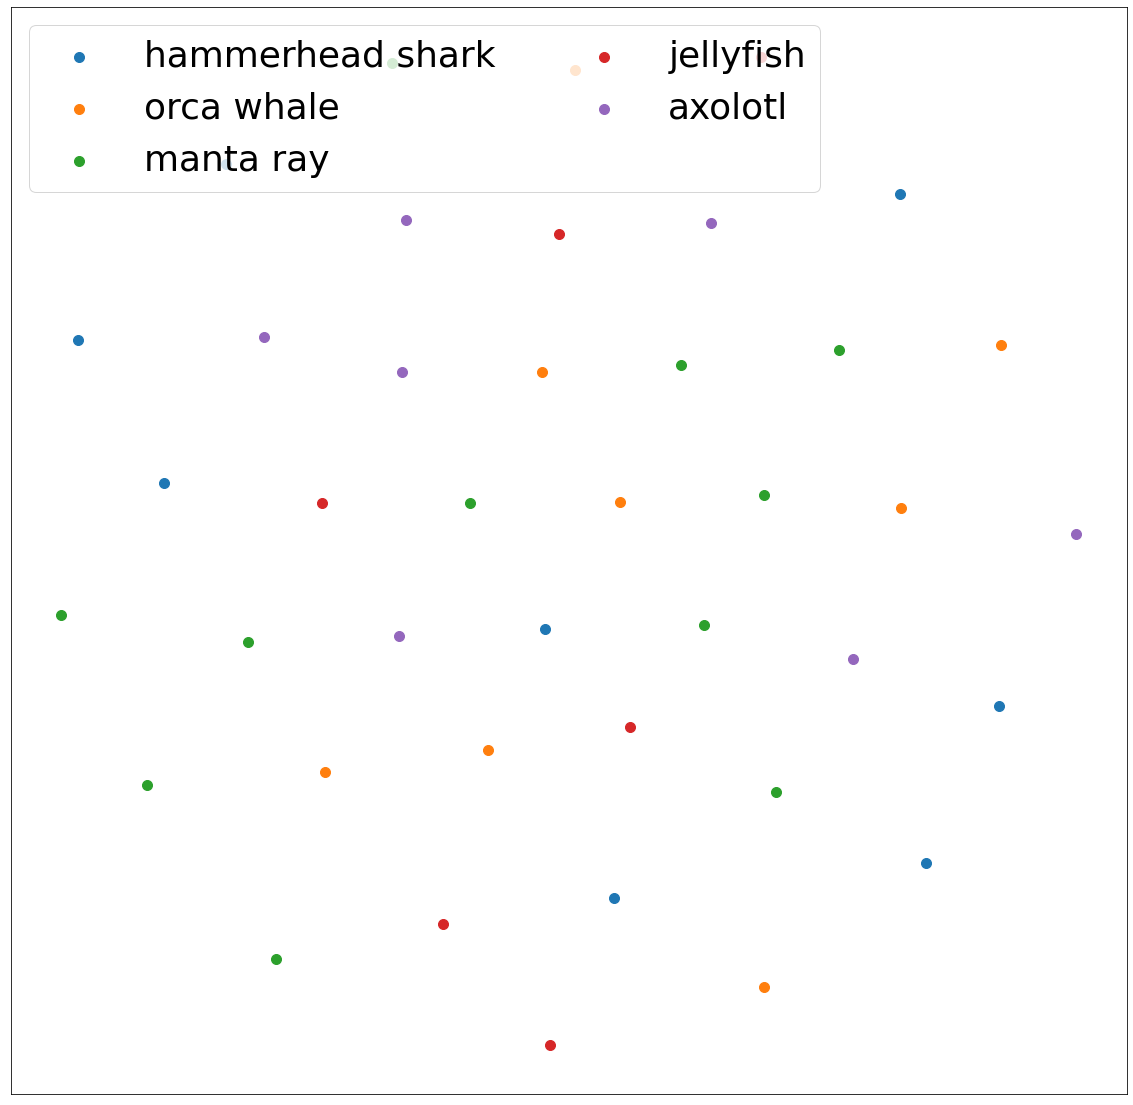

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for i in range(len(class_names)):
    sel_inds = np.argwhere(labels == i).flatten()
    ax.scatter(tsne_feats[:, 0][sel_inds], tsne_feats[:, 1][sel_inds], label=class_names[i], s=100)
    
ax.legend(fontsize=36, ncol=2, loc=2)
ax.set_xticks([])
ax.set_yticks([])